# Introduction to Neural Networks

-----

In this notebook, we introduce the [Neural Network (NN) algorithm][wnn], a powerful, supervised learning approach to make predictions. Neural networks were originally inspired by biological neural networks (i.e., brains). First, we will explore the basic neural network algorithm focusing on the perceptron, and more complex approaches called multi-layer perceptrons, which are based on the fundamental concept. Next, we will apply the neural network algorithm to classification tasks, including an exploration of how different hyperparameters affect its performance. Finally, we will apply the neural network algorithm for regression.

-----
[wnn]: https://en.wikipedia.org/wiki/Artificial_neural_network

## Table of Contents

[Formalism](#Formalism)

[Neural Network: Classification](#Neural-Network:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Neural Network: Decision Surface](#Neural-Network:-Decision-Surface)
- [Neural Network: Hyperparameters](#Neural-Network:-Hyperparameters)
- [Classification: Adult Data](#Classification:-Adult-Data)

[Neural Network: Regression](#Neural-Network:-Regression)

- [Regression: Auto MPG Data](#Regression:-Auto-MPG-Data)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

A [neural network][wann] is designed to mimic natural intelligence, which is believed to involve a set of interconnected [neurons][wn], which form a _network_. In this natural network, signals propagate between neurons via [synapses][ws], and if the signal is sufficient, the receiving neurons propagate the signal forward through the network. These natural networks involve huge numbers of neurons, the exact number varying between species. For example, an average human is believed to have around 85 billion neurons. There are vastly more synapses that connect these neurons, a typical human is believed to have around 1,000 trillion synapses.

This natural model introduces several important concepts, which are relevant to neural network algorithms. First, a neural network is built from a network of interconnected nodes. Second, there are many more interconnections than nodes. Third, a node has an activation function that determines if input signals are propagated forward. The activation function can be a simple threshold, or a more complex function that applies weights to the input signals. 

These concepts are demonstrated in the following figure, where we have a set of input nodes on the far left, that are connected to the first layer of artificial neurons (light red). This layer of nodes is hidden from the user, and can have connections to other hidden layers. At the end of this hidden network, the final layer, shown in light blue in the figure, has connections to the output layer. In the image, the output layer consists of a single node, which would correspond to a binary classification (i.e., on or off).

![ANN Image (RJB)](images/ann-rjb.png)

Designing the network used to make predications for a given problem can be difficult. The number and size of the hidden layers are hyperparameters, which can result in a huge number of possible variations. Another hyperparameter is the activation function used in each node, which controls what signals are propagated forward. In addition, overfitting is always a concern when building large networks. To minimize the likelihood of overfitting, we can apply regularization, which is controlled by another hyperparameter. 

The rest of this notebook  demonstrates how to apply neural networks by using the scikit learn library for classification and regression tasks, and will look at the effects of these hyperparameters on the performance of this algorithm. To start, we load the Iris data in the following Code cell into the notebook and divide these data into training and testing samples.


-----
[wann]: https://en.wikipedia.org/wiki/Artificial_neural_network
[wn]: https://en.wikipedia.org/wiki/Neuron
[ws]: https://en.wikipedia.org/wiki/Synapse

In [2]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.4

# Load, but don't plot the data
show_plot = False

d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)

-----

[[Back to TOC]](#Table-of-Contents)


## Neural Network Classification

With a discussion on the architecture of a neural network algorithm complete, we can now introduce how to perform [Neural Network classification][sknnc] by using the scikit-learn library. This will require creating the `MLPClassifier` in the `neural_network` module. The `MLPClassifier` estimator accepts a number of hyperparameters that control how it performs, some of the more useful hyperparameters include:

- `hidden_layer_sizes`: defines the neural network architecture, and accepts a tuple whose length specifies the number of hidden layers, and whose values specifies the number of nodes in each layer. Default value is `(100,)` which is a single hidden layer with one hundred nodes. 

- `activation`: specifies the activation function for the nodes in the hidden layer, and can be `identity`, `logistic`, `tanh`, and `relu`, which is the default.

- `alpha`: an $L2$ regularization parameter.

- `solver`: the algorithm used to optimize the weights that apply to the inputs at each node in the hidden layers.

- `random_state`: seed for random number generation, setting this ensures reproducibility.

To demonstrate how to use a neural network for a classification task, we will use the Iris data set. With these data, we will create a neural network estimator that employs the default activation function, a random seed, and a simple network architecture of two hidden layers, each with eight nodes. Next, we fit this estimator to our training data, and produce an accuracy metric. As the following Code cell demonstrates, our straightforward application of a neural network to these data generates a very robust prediction. The two Code cells that follow the first display the classification report and confusion matrix for this prediction task, which once again indicates that the neural network has performed very well on these data.

-----

[sknnc]: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [3]:
# Next lets try SVM
from sklearn.neural_network import MLPClassifier

# Use default parameters, except we want two layer network
# and we specify the random_state hyperparameter to 
# ensure reproduceability.
iris_model = MLPClassifier(alpha=0.25,
                           hidden_layer_sizes=(8, 8), 
                           max_iter=500,
                           random_state=23)

# Fit our model
iris_model = iris_model.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * iris_model.score(d_test_sc, l_test)
print(f"NN prediction accuracy = {score:5.1f}%")

NN prediction accuracy =  96.7%


In [4]:
from sklearn.metrics import classification_report

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = iris_model.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        21
 Versicolor       0.90      1.00      0.95        18
  Virginica       1.00      0.90      0.95        21

avg / total       0.97      0.97      0.97        60



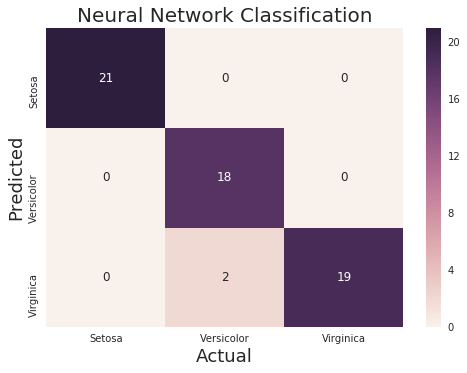

In [5]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             y_pred, labels, 3, 
             'Neural Network Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Neural Network:  Decision Surface

The neural network we constructed for the Iris data employed a relatively simple architecture, two hidden layers, each with eight nodes. Thus, the class divisions within our data should not be overly complex. To explore the nature of these divisions, we construct and display a decision surface in the following Code cell for our Iris data. In this case, we must restrict our data (and model) to two dimensions: Sepal Width and Petal Width in order to easily visualize the decision surface. 

The visualization displays both the training data and the decision surface, which clearly shows nearly linear splits between the three classes. Note that the splits are not parallel to the axes, instead they divide the data based on combinations of these features. The top division is effectively two linear cuts, while the bottom division is slightly curved. For these data, we have four misclassifications, which is reasonable, but most data sets are not this cleanly divisible. 

-----

NN accuracy =  95.0%


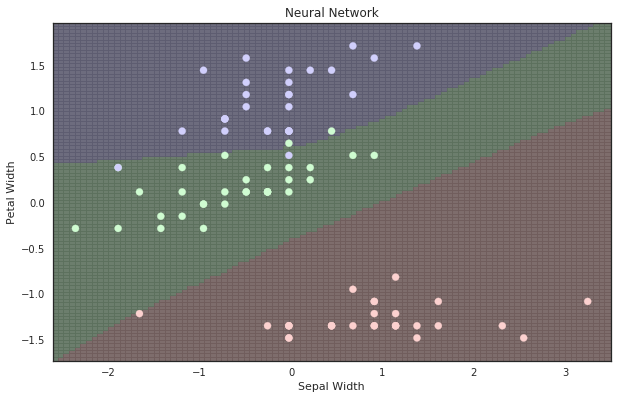

In [6]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)
t_data = hi.trim_data(d_test_sc, l_test)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
iris_model.fit(n_data[:,:2], n_data[:,2])
    
# Compute and display accuracy score
score = 100.0 * iris_model.score(t_data[:,:2], t_data[:,2])
print(f"NN accuracy = {score:5.1f}%")    

# Predict for mesh grid
z = iris_model.predict(mdata)
    
# Plot training data and mesh grid
hi.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)

# Provide title for plot, the trailing semicolon
# is used to prevent the printing of the plot object details
ax.set_title(f'Neural Network') ;

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding Code cells, we used a simple neural network to predict classifications for the Iris data. Now that you have run the notebook once, go back and make the following changes to see how the results change.

1. Change the training to testing split size, for example change from a 60%:40% to a 75%:25%, and to a 50%:50%.
2. Change the random_state hyperparameter in the NN algorithm.

Finally, how does the decision surface compare to the decision surface computed for another classification algorithm, such as the k-nn, decision tree, SVC, or logistic regression?

-----

-----

[[Back to TOC]](#Table-of-Contents)

### Neural Network: Hyperparameters

One of the most important hyperparameters for a neural network is the `activation` hyperparameter, which specifies the activation function that each node in the network uses to propagate forward information. In the original neural network we created earlier in this notebook, we used  a `relu` function, which stands for [rectified linear unit][wrelu]. This function, $f(x)$, is defined to be the maximum of either zero or $x$, the input value. In the following Code cell, we compute and display decision surfaces for NNs that employ different activation functions: `identity`, `logistic`, and `tanh`. By doing this, the resulting figures demonstrate how these different kernels affect the overall classification. 

Notice how the resulting decisions surfaces are dominated by linear divisions. This is the result of the original network architecture, recall that `hidden_layer_sizes=(8, 8)`, that we use for this test. We will explore the effect of changing the architecture in the next hyperparameter test.

Each of the last three decision surfaces have curved hyperplanes in the original space, since they transform the original data by using non-linear functions. Interestingly enough, two of the new estimators improve the classification efficacy over that of the default activation function, although only marginally. On the other hand, the `logistic` activation function performs noticeably worse. This example nicely demonstrates the importance of evaluating different hyperparameters to determine the optimal model, which can be done by employing a cross-validation grid search.

----
[wrelu]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

NN (Activation=identity) accuracy =  96.7%
NN (Activation=logistic) accuracy =  83.3%
NN (Activation=tanh) accuracy =  96.7%


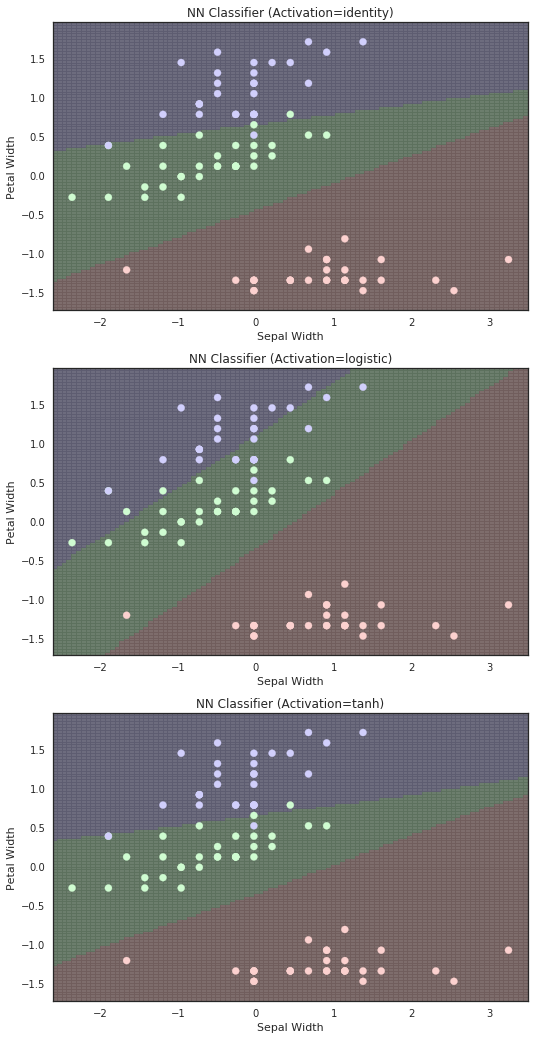

In [7]:
# Define NN architectures
act_funcs = ['identity', 'logistic', 'tanh']

# Show the mesh grid and training data
fig, axs = plt.subplots(figsize=(10,6 * len(act_funcs)), 
                        nrows=len(act_funcs), ncols=1, 
                        sharex=False)

# Iterate through different activation functions
for idx, af in enumerate(act_funcs):
    
    # Now train our model
    iris_model.set_params(alpha=0.25,
                          activation=af, 
                          hidden_layer_sizes=(8, 8), 
                          max_iter=500,
                          random_state=23)
    
    # Now train our model
    iris_model.fit(n_data[:,:2], n_data[:,2])
    
    # Compute and display accuracy score
    score = 100.0 * iris_model.score(t_data[:,:2], t_data[:,2])
    print(f"NN (Activation={af}) accuracy = {score:5.1f}%")    
    
    # Predict for mesh grid
    z = iris_model.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'NN Classifier (Activation={af})')

-----

We can also change the number and size of the hidden layers to explore the effect of this hyperparameter on the performance of the neural network on the Iris data. For this task, we select the `relu` activation function, set `alpha=0.5` to provide a measure of regularization, to reduce the chance of overfitting, and generate the decisions surfaces for four different network architectures: (5, 10, 5), (10, 20, 10), (5, 10, 10, 5), (10, 10, 10, 10, 10). The performance of all four networks is reasonable and the decision surfaces all show non-linearities, but the nature of the non-linearities vary from highly curved for the first network, to shallower curves for the last network. While not definitive, this simple example demonstrates how different network architectures can impact performance.

-----

NN (5, 10, 5) accuracy =  93.3%
NN (10, 20, 10) accuracy =  95.0%
NN (5, 10, 10, 5) accuracy =  91.7%
NN (10, 10, 10, 10, 10) accuracy =  96.7%


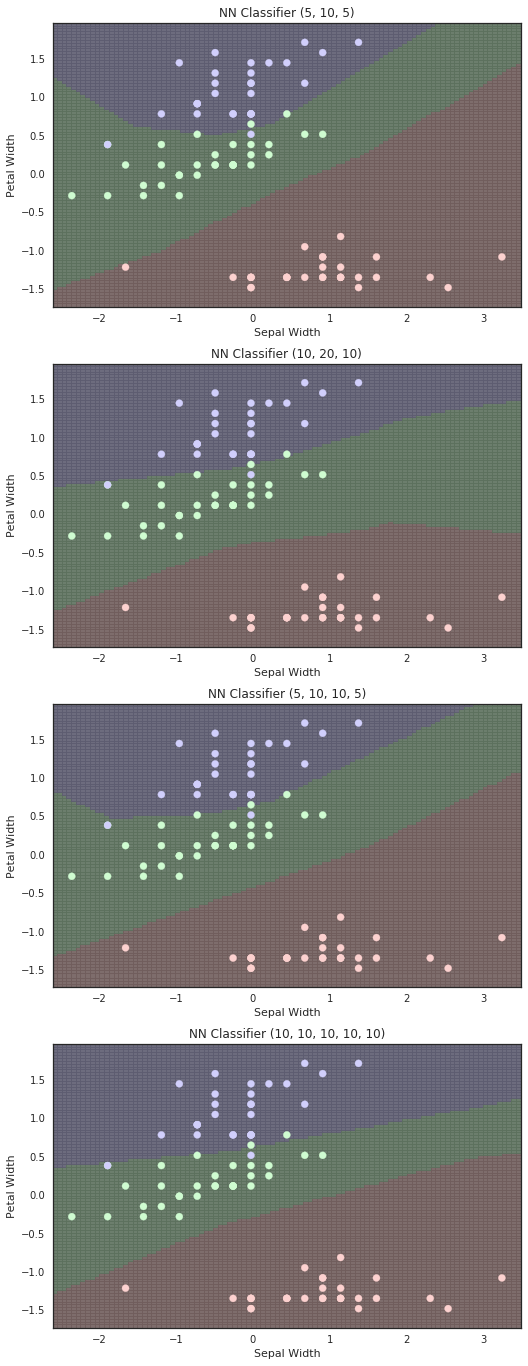

In [8]:
# Define NN architectures
hidden_layers = [(5, 10, 5), (10, 20, 10), 
                (5, 10, 10, 5), (10, 10, 10, 10, 10)]

# Show the mesh grid and training data
fig, axs = plt.subplots(figsize=(10,6 * len(hidden_layers)), 
                        nrows=len(hidden_layers), ncols=1, 
                        sharex=False)

# Iterate through different activation functions
for idx, hl in enumerate(hidden_layers):
    
    # Now train our model
    iris_model.set_params(alpha=0.5,
                          activation='relu',
                          hidden_layer_sizes=hl, 
                          random_state=23)
    
    # Now train our model
    iris_model.fit(n_data[:,:2], n_data[:,2])
    
    # Compute and display accuracy score
    score = 100.0 * iris_model.score(t_data[:,:2], t_data[:,2])
    print(f"NN {hl} accuracy = {score:5.1f}%")    
    
    # Predict for mesh grid
    z = iris_model.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'NN Classifier {hl}')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we employed different activation functions and neural network architectures to explore how the decision surfaces changed. Now that you have run the notebook once, go back and make the following changes to see how the results change.

1. Change the `activation` hyperparameter to `identity` and redo the architecture hyperparameter test.
2. Change the `activation` hyperparameter to `tanh` and redo the architecture hyperparameter test.
3. Change the `hidden_layer_sizes` hyperparameter to other architectures (you can choose the number of layers and the size of each layer).

How does the decision surface change as these hyperparameters change? Does the accuracy improve or get worse?

-----

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now transition to a more complex data set, the adult data from the UCI machine learning repository. These data are fully documented online at the UCI website, and were used and discussed originally in the Introduction to Decision Tree notebook. The following two Code cells first define the local filename where we wish to store these data, and if the file does not yet exist, uses the `wget` commend to grab these data from the UCI repository.

-----

[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult
[idt]: intro2dt.ipynb

In [9]:
# Adult data file from UCI ML Repository
# http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# First we find our HOME directory
tmp = !echo $HOME

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/adult.data'

In [10]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

We now have the data stored locally, and can proceed to read the data into a DataFrame so we can process it appropriately before applying neural network classification. Once we have read the data into a DataFrame by using the `read_csv` method, we can create a binary label feature to indicate people with salaries below \$50K, or class 0, and people with salaries above \$50K, or class 1. Once this step is done, we drop the original feature, and extract those features that we will use.

For this classification task, we will start by selecting six categorical features and five numerical features. We extract these different sets of features form the original DataFrame and create a new `features` DataFrame to hold the features of interest. We end the following Code cell by randomly sampling five instances from our new data set.

-----

In [11]:
# Adult data archived at UCI ML Repository
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 
             'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data from URL return Pandas
adult_data = pd.read_csv(data_url, index_col=False, names = col_names)

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Now we can drop the original column
adult_data = adult_data.drop('Salary', axis=1)

# Exract categorical features
categorical = ['Education', 'Workclass', 'Race', 
               'Sex', 'Occupation', 'Relationship']
cat_data = pd.get_dummies(adult_data[categorical])

# Extract numerical features
numerical = ['Age', 'EducationLevel', 'HoursPerWeek', 
             'CapitalGain', 'CapitalLoss']
num_data = adult_data[numerical]

# Extract labels

labels = adult_data['Label']

# Create feature DataFrame
features = pd.concat([num_data, cat_data], axis=1)
features.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,...,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Relationship_ Husband,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife
7043,41,16,50,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
24519,37,11,40,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
205,18,7,40,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3354,26,7,20,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25122,45,9,40,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


-----

With the data now loaded into a DataFrame in our notebook, we can move on to creating our training and testing data sets, and employing neural network classification.

-----

In [12]:
from sklearn.model_selection import train_test_split

frac = 0.4
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

----

With our data now divided into training and testing, we now apply a neural network to classify these data. In the following Code cell, we create a `MLPClassifier` estimator, and train this estimator with the training data. These training data are actually rather large, consisting of nearly 20,000 instances each with 58 features. With the selected hyperparameters, this estimator achieves reasonable performance. But as the classification report demonstrates, the positive class, which is higher salary people, has  fewer instances along with degraded performance, although it is still better than many other standard machine learning algorithms.

-----

In [13]:
adult_model = MLPClassifier(alpha=0.5, activation='logistic',
                            hidden_layer_sizes=(50,50,50), max_iter=500)
adult_model = adult_model.fit(d_train, l_train)

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * accuracy_score(l_test, predicted)
print(f'NN Classification [Adult Data] Score = {score:4.1f}%\n')

print('Classification Report:\n {0}\n'.format(
    classification_report(l_test, predicted)))

NN Classification [Adult Data] Score = 83.2%

Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.95      0.90      9811
          1       0.76      0.47      0.58      3214

avg / total       0.82      0.83      0.82     13025




-----

[[Back to TOC]](#Table-of-Contents)

## Neural Network: Regression

To this point, we have only applied a neural network to classification tasks. This algorithm, and specifically the multi-layer perceptron, can also be applied to regression tasks. To perform neural network regression, we will use the `MLPRegressor` estimator in the `neural_network` module in the scikit-learn library. This estimator accepts a very similar list of hyperparameters to the `MLPClassifier` estimator discussed earlier in this notebook. 

In the rest of this section, we demonstrate how to perform neural network regression on a complex data set, in this case the automotive fuel prediction data, also used in previous notebooks. Note that in the following example, we have not normalized the numerical features. While this obviously can affect performance, we leave that as a student exercise.




-----

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

To demonstrate neural network regression, we will use the automobile fuel efficiency data set from the UCI machine learning repository. We first introduced these data in the Introduction to Decision Tree notebook. For more information on these data, refer to the [online documentation][od] at the UCI website.

In the following Code cells, we load these data into our notebook, construct a neural network predictive model, and evaluate its performance. The first two Code cells first construct the full path to the local copy of this data. If the file does not exist, we grab it from the UCI repository by using the `wget` command.

----

[idt]: intro2dt.ipynb
[od]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [15]:
# Auto MPG data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/auto-mpg.data'

In [16]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

With the data file now available locally, we can read this data into our notebook as a pandas DataFrame. The columns are delimited by whitespace, so we indicate this to the `read_csv` method and explicitly provide the column names. With this DataFrame, we finish the following Code cell by dividing these data into training and testing sets.

-----

In [17]:
import patsy as pts 

# Feature names
col_names = ['MPG', 'Cylinders', 'Displacement',
             'Horsepower', 'Weight', 'Acceleration', 
             'Year', 'Origin', 'Name']

# Read in the DataFrame, features are delimited by whitespace
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)

# Create feature and label DataFrames using formula-based interface
y, x = pts.dmatrices('MPG ~ C(Cylinders) + Displacement + Horsepower + ' +
                     'Weight + Acceleration + C(Year) + C(Origin)', 
                     data=auto_data, return_type='dataframe')

# Split data into training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

-----

With these data now loaded into a DataFrame and split into training and testing samples, we can create a regression model by using the `MLPRegressor` estimator in the `neural_network` module in the scikit-learn library. First, we create our estimator, in this case we use hyperparameters that give reasonable results. Next, we fit the model to our training data. Finally, we compute a regression score, which by default is $R^2$, or the coefficient of determination. Our computed score is not great, however, for a first application of neural networks for regression, the value is reasonable. 

The second Code cell computes and displays other metrics, which in this case provide more insight into our performance. For example, the mean and median absolute errors indicate that we predict the miles per gallon for an automobile in the test data set within about 3.75 miles per gallon, which is similar to the best performance for other machine learning techniques. To improve performance, we can either perform grid search to determine the best combination of hyperparameters (including the number and size of the hidden layers), but we also can use residual plots to quantify which features provide the most (and least) predictive power.

-----

In [18]:
from sklearn.neural_network import MLPRegressor

# Create Regressor with specific hyperparameters
auto_model = MLPRegressor(alpha=0.5, activation='tanh',
                          hidden_layer_sizes=(150, 250, 150), 
                          random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
scr = auto_model.score(ind_test, dep_test)
print(f'Regression Score = {scr:5.3f}')

Regression Score = 0.581


In [19]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 3.75
Mean Squared Error    = 22.58
Median Absolute Error = 3.02
R^2 Score             = 0.581
Explained Variance    = 0.584


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used neural network regression to model the fuel efficiency of automobiles. Try to improve the results by making the following changes. As you try these tasks, try to understand what has changed and if the change is good or bad.

2. Iteratively remove one or more of the categorical features from the training data.
3. Change the fraction of data held out for testing.
5. Try using a different activation function.
4. Try using different values for the hidden-layers (both number of layers, and the number of units in the different layers).

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. An introduction to neural networks, [Part 1][inn1] and [Part 2][inn2] in Python
5. A discussion on the [perceptron][2] in Python
6. A beginner's guide to [neural networks][bgi] with Scikit learn
7. The scikit learn documentation for the [Multilayer Perceptron][mp]

-----

[inn1]: https://iamtrask.github.io/2015/07/12/basic-python-network/
[inn2]: https://iamtrask.github.io/2015/07/27/python-network-part2/
[2]: https://glowingpython.blogspot.com/2011/10/perceptron.html
[bgi]: https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/
[mp]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode